### Nacitanie potrebnych kniznic

### Changelog 1

1. uprava diskriminatora (enforcnutie vah, normalizacia) 
    - zahrnuli sme l2 regularizer pre upravu vah
    - inicializacia vah sa neosvedcila (ani He, ani random_normal)
    - batch normalizacia prepalila obrazky po par batchoch na cisto bielu (co moze byt lebo moc velke momentum, nakoniec sme nepouzivali normalizaciu vobec)
 
2. finetuning vah  pre diskriminator a generator - mozno hrat sa na grayscale datach pre jednoduchost
    - pre tuning vah pocas trenovania je parameter trainable, ktory je pre diskriminator nastaveny default na False a zmeni sa pocas trenovania na True pre upravu vah a potom naspat na False

3. uprava vstupnych dat - gan sa focusuje na najsvetlejsie body tvare, uprava kontrastu (vytahovanie najdolezitejsich crtov)
    - skusanie manualneho upravovania kontrastu, neosvedcilo sa - normalizacia na [-1,1] nam uz upravuje kontrast
    - ekvalizovanie kontrastu pre vsetky obrazky a kanaly rovnako pomocou funkcie equalizeHist - aj napriek tomu ze obcas nechcene zvyrazni urcite prvky v pozadi sme ponechali tuto metodu

4. pooling pre okraje obrazka (rozsirit obrazok nasilu), stochastic pooling?
    - tu sme pouzili funkciu cv2.copyMakeBorder pre ukazku sme pouzili 10px v treningu 1px

5. pohrat sa s blokmi - resnet ako inspiracia?
    - pri generatore sme pouzili residual bloky

### Changelog 2

6. posielat obrazky do wandb
    - implementovali sme wandb do nasho treniningu a posielame aj obrazky pre kazdu epochu
    
7. ina metoda na pooling pri prepaloch (stochastic, s3)
    - pre pooling sme vyskusali metodu AveragePoooling2D ale MaxPooling bol lepsi 
    
8. odstranit background (r cnn) a čistenie dat
    - odstranenie backgroundu nedava v tomto pripade zmysel, lebo su data rozne a niektore neobsahuju takzmer ziadny background
    - cistenie je casovo narocne a vyrazne by sa zredukovala velkost datasetu

9. v batch normalizacii v diskriminatore nastavit momentum na nizsie ak by sme to tam dali
    - vyskusane s momentum 0.8 pre normalizaciu po 3 konvolucnych blokoch v diskriminatore. stale avsak nastava problem so "silou" a prepalovanim obrazkov. vo vysledku nezostanu uplne biele ale model ma problem triafat farby

10. na inicializaciu vah bud kernel_initializer=tf.random_normal_initializer(0.,0.002))(x) +zmena learning_rate alebo He inicializacia
    - vysssi learning rate nepomohol nasej sieti taktiez nastavenie nahodneho inicializera na hodnoty az 0.002 nedavalo zmysel, generator generoval zle vystupy

11. diskriminator inicializacia vah
    - zahrnute uz aj vramci prveho bodu changelogu avsak inicializacia vah (aj He aj random_normal) sposobuju vyssi loss pre diskriminator

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import time
import tensorflow as tf
import wandb
from tensorflow.keras import layers
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Zobrazenie realnej a komixovej tvare s ramom 10px vo vsetkych stranach

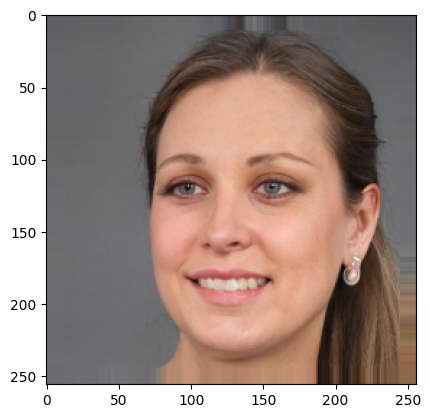

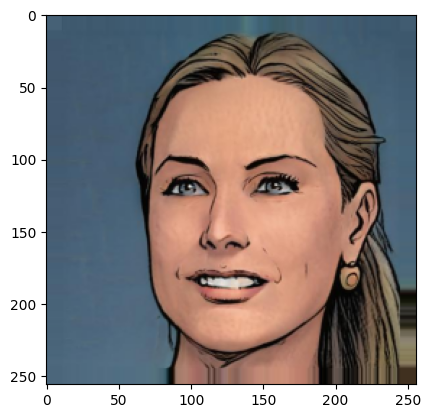

In [2]:
# changelog 4.
plt.imshow(cv2.copyMakeBorder(cv2.cvtColor(cv2.resize(cv2.imread('../input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/1002.jpg'), (236,236), interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2RGB), 10, 10, 10, 10, cv2.BORDER_REPLICATE))
plt.show()
plt.imshow(cv2.copyMakeBorder(cv2.cvtColor(cv2.resize(cv2.imread('../input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/1002.jpg'), (236,236), interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2RGB), 10, 10, 10, 10, cv2.BORDER_REPLICATE))
plt.show()

### Nacitanie ciest ku vsetkym obrazkom

In [3]:
face_routes = sorted(glob.glob('/kaggle/input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/*.jpg'))
comic_routes = sorted(glob.glob('/kaggle/input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/*.jpg'))

In [ ]:
with tf.device('/gpu:0'):
    # downsample blok pre generator
    def downsample_block(filters, kernel_size=3, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=2):
        block = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, strides=strides, kernel_initializer=tf.random_normal_initializer(0.,0.02)),
            layers.BatchNormalization(),
            layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, strides=strides, kernel_initializer=tf.random_normal_initializer(0.,0.02)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2))
            # changelog 7.
            #layers.AveragePooling2D(pool_size=(2, 2))

        ])
        return block
    # upsample blok pre generator
    def upsample_block(filters, kernel_size=3, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=2):
        block = tf.keras.Sequential([
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, strides=strides, kernel_initializer=tf.random_normal_initializer(0.,0.02)),
            layers.BatchNormalization(),
            layers.Dropout(0.01),
            layers.Conv2D(filters, kernel_size, activation=activation, padding=padding, strides=strides, kernel_initializer=tf.random_normal_initializer(0.,0.02)),
            layers.BatchNormalization(),
        ])
        return block
    
    # residualny blok pre generator
    def residual_block(x, filters, kernel_size):
        x_input = x
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer=tf.random_normal_initializer(0.,0.02))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(layers.LeakyReLU(alpha=0.2))(x)
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer=tf.random_normal_initializer(0.,0.02))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, x_input])
        x = layers.Activation(layers.LeakyReLU(alpha=0.2))(x)
        return x
    # definovanie generatora  
    def gen(input_shape):
        inputs = layers.Input(shape=input_shape)

        conv1 = downsample_block(64, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(inputs)
        conv2 = downsample_block(128, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(conv1)
        conv3 = downsample_block(256, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(conv2)
        conv4 = downsample_block(512, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(conv3)
        conv5 = downsample_block(1024, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(conv4)
        
        in_layer = conv5
        for i in range(4):
            # changelog 5.
            out_layer = residual_block(in_layer,1024,(3,3))
            in_layer = out_layer

        up1 = upsample_block(1024, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(out_layer)
        merge1 = layers.Concatenate()([up1, conv4])
        up2 = upsample_block(512, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(merge1)
        merge2 = layers.Concatenate()([up2, conv3])
        up3 = upsample_block(256, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(merge2)
        merge3 = layers.Concatenate()([up3, conv2])
        up4 = upsample_block(128, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(merge3)
        merge4 = layers.Concatenate()([up4, conv1])
        up5 = upsample_block(64, 5, activation=layers.LeakyReLU(alpha=0.2), padding='same', strides=1)(merge4)
        outputs = layers.Conv2D(3,5, padding='same', activation='tanh')(up5)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    generator = gen((256, 256, 3))
    
    # definovanie discriminatora
    discriminator = tf.keras.models.Sequential([
            layers.Input(shape=(256, 256, 3)),
            layers.Dropout(0.2),
            # changelog 1 a 11.   
            layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.BatchNormalization(momentum=0.8),
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid"),
    ])

    generator.summary()

    discriminator.summary()
    # definovanie GAN 
    gan = tf.keras.models.Sequential([
        generator,
        discriminator,
    ])
    
    # skompilovanie s loss funkciou binary crossentropy
    discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

    discriminator.trainable = False

    gan.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               

                                )]                                                                

                                                                                                  

 sequential (Sequential)        (None, 128, 128, 64  107840      ['input_1[0][0]']                

                                )                                                                 

                                                                                                  

 sequential_1 (Sequential)      (None, 64, 64, 128)  615680      ['sequential[0][0]']             

                                                                                   

In [5]:
wandb.init(project="Nsiete_zadanie3")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# only for additional training
gan = tf.keras.models.load_model('../input/ganh5/gan.h5')
generator_layer = gan.layers[0]
generator = tf.keras.models.Sequential(generator_layer)
dis_layer = gan.layers[1]
discriminator = tf.keras.models.Sequential(dis_layer)
discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
gan.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

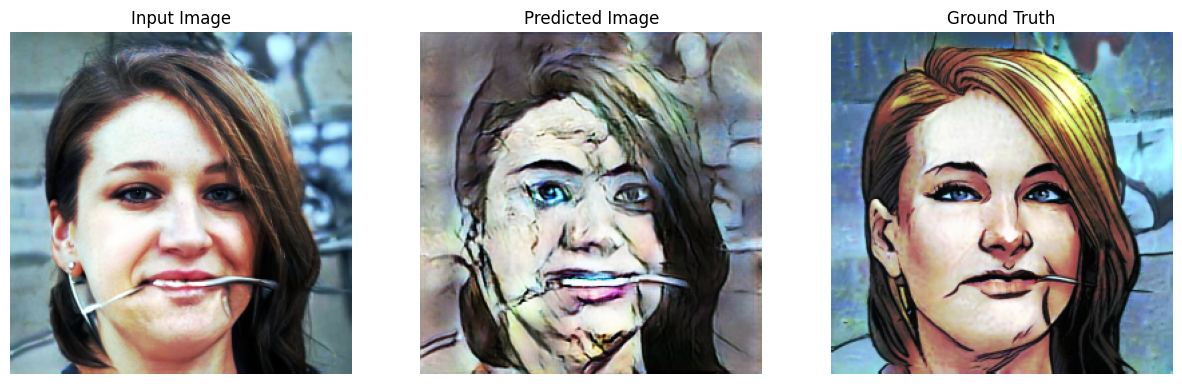

In [ ]:
# nastavenie hyperparametrov
epochs = 25
batch_size = 10
wandb.config.batch_size = batch_size
wandb.config.epochs = epochs
wandb.config.optimizer_learning_rate = 0.0002
wandb.config.regularizer_learning_rate = 0.01
wandb.config.dropout_rate = 0.01
wandb.config.beta = 0.5
wandb.config.kernel_inicializer = 0.02


with tf.device('/gpu:0'):
    # vytvoranie mnoziny pre treningdiskriminatora 
    def get_training_batch(fake_images, comics, batch_size):
        idx = np.random.randint(0, len(comics), batch_size)
        real_batch = comics[idx]
        generated_batch = fake_images.numpy()[idx]
        real_labels = np.ones((batch_size, 1))
        generated_labels = np.zeros((batch_size, 1))
        X = np.concatenate([real_batch, generated_batch])
        y = np.concatenate([real_labels, generated_labels])
        
        idx = np.random.permutation(len(X))
        X = X[idx]
        y = y[idx]
        return X, y
    # trenovanie
    def train_gan(generator, discriminator, gan, epochs, batch_size):
        for epoch in range(epochs):
            start = time.time()
            counter = 0
            epoch_d_loss = 0
            epoch_g_loss = 0
            min_loss = 0
            for j in range((len(face_routes)//batch_size)):
                faces = []
                comics = []
                # nacitanie obrazkov pre dany batch
                for i in range(j*batch_size,(j+1)*batch_size):
                    img = cv2.imread(face_routes[i])
                    
                    b, g, r = cv2.split(img)

                    eqb = cv2.equalizeHist(b)
                    eqg = cv2.equalizeHist(g)
                    eqr = cv2.equalizeHist(r)

                    merged_img = cv2.merge((eqb, eqg, eqr))

                    img = cv2.resize(merged_img, (254,254), interpolation = cv2.INTER_AREA)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # changelog 4.
                    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
                    img = (img / 127.5) - 1
                    faces.append(img)
                    img = cv2.imread(comic_routes[i])
                    
                    b, g, r = cv2.split(img)

                    eqb = cv2.equalizeHist(b)
                    eqg = cv2.equalizeHist(g)
                    eqr = cv2.equalizeHist(r)

                    merged_img = cv2.merge((eqb, eqg, eqr))

                    img = cv2.resize(merged_img, (254,254), interpolation = cv2.INTER_AREA)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # changelog 4.
                    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
                    img = (img / 127.5) - 1
                    comics.append(img)
                    
                faces = np.array(faces)
                comics = np.array(comics)
                # predikovanie komixovych tvari pre diskriminator a GAN celu 
                fake_images = generator(faces, training=True)
                # vytvoranie mnoziny pre trening diskriminatora 
                X, y = get_training_batch(fake_images, comics, batch_size)

                discriminator.trainable = True
                #trening diskriminatora 
                d_loss = discriminator.train_on_batch(X, y)
                counter = counter + 1 
                epoch_d_loss = epoch_d_loss + d_loss
                
                discriminator.trainable = False
                #trening GAN
                g_loss = gan.train_on_batch(fake_images, np.ones((batch_size, 1)))
                epoch_g_loss = epoch_g_loss + g_loss
                
                print(f"Batch {j},Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}, Min Generator Loss: {min_loss}#######################", end='\r')
                
                if min_loss == 0:
                    min_loss = g_loss
                if g_loss < min_loss:
                    min_loss = g_loss
                    
                # zobrazovanie povodneho, vygenerovaneho a komixoveho obrazku vedla seba
                if j % 50 == 0:
                    clear_output(wait=True)
                    plt.figure(figsize=(15, 15))
                    display_list = [faces[0], fake_images[0], comics[0]]
                    title = ['Input Image','Predicted Image', 'Ground Truth']
                    for i in range(3):
                        plt.subplot(1, 3, i+1)
                        plt.title(title[i])
                        plt.imshow(display_list[i] * 0.5 + 0.5)
                        plt.axis('off')
                    plt.show()
            
            print("Epoch time: ",time.time() - start)
            
            print(f"Epoch {epoch}, Discriminator Loss: {epoch_d_loss/counter}, Generator Loss: {epoch_g_loss/counter}")
            wb_face = wandb.Image(
                faces[2], 
                caption="Face"
                )
            wb_pred = wandb.Image(
                fake_images[2], 
                caption="Prediction"
                )
            wb_target = wandb.Image(
                comics[2], 
                caption ="Target"
                )
            # changelog 6.
            wandb.log({"Discriminator Loss": epoch_d_loss/counter, "Generator Loss": epoch_g_loss/counter, "Face": wb_face, "Prediction": wb_pred, "Target": wb_target})
#         wandb.finish();
    train_gan(generator, discriminator, gan, epochs, batch_size)
    

In [ ]:
# ulozenie a stiahnutie modelu vramci kaggle
gan.save('/kaggle/working/model/gan.h5')
discriminator.save('/kaggle/working/model/discriminator.h5')
generator.save('/kaggle/working/model/generator.h5')

import os
from IPython.display import FileLink
os.chdir('/kaggle/working/')
FileLink(r'generator.h5')

# wandb.save('/kaggle/working/model/gan.h5')
# wandb.save('/kaggle/working/model/discriminator.h5')
# wandb.save('/kaggle/working/model/generator.h5')

### Testovanie na novych tvarach (celebrit) z celeb datasetu

In [44]:
gan = tf.keras.models.load_model('../input/ganh5/gan.h5')
generator_layer = gan.layers[0]
generator = tf.keras.models.Sequential(generator_layer)

In [45]:
celeb_routes = sorted(glob.glob('/kaggle/input/celebxichty/celeb_faces/*.jpg'))
celebs = []

In [46]:
for i in range(3):
    img = cv2.imread(celeb_routes[i])
    img = cv2.resize(img, (254,254), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    img = (img / 127.5) - 1
    celebs.append(img)

In [47]:
fake_images = []
with tf.device('/gpu:0'):
    for i in range(3):
        img = tf.expand_dims(celebs[i], axis=0)
        fake_images.append(generator(img, training=False)) 

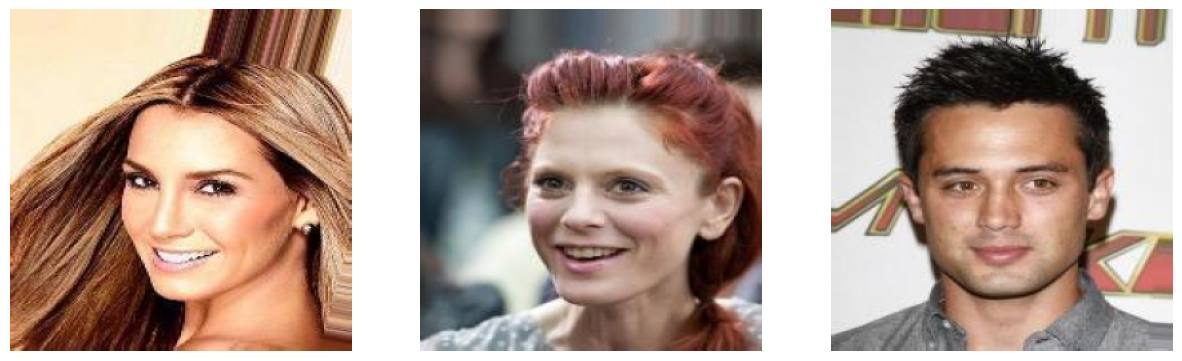

In [48]:
plt.figure(figsize=(15, 15))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(celebs[i] * 0.5 + 0.5)
    plt.axis('off')
plt.show()

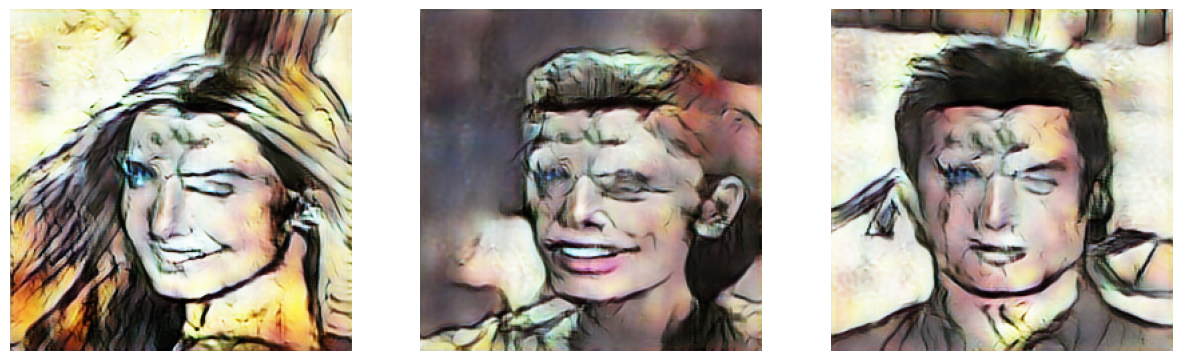

In [49]:
plt.figure(figsize=(15, 15))
for i in range(3):
    plt.subplot(1, 3, i+1)
    img = np.squeeze(fake_images[i].numpy(), axis=0)
    plt.imshow(img * 0.5 + 0.5)
    plt.axis('off')
plt.show()

In [ ]:
wandb.finish()

<img src="nase_tvare.png" width="768" height="768">

<img src="best1.png">

<img src="best2.jpg">

<img src="best3.jpg">


Link na wandb a runy:

https://wandb.ai/nsiete23-gaza-kuran/Nsiete_zadanie3